In [1]:
import numpy      as np
import pandas     as pd
import yfinance   as yf      #yahoo finance api package
import seaborn    as sns

from sklearn.model_selection import train_test_split

from xgboostlss.model import *
from xgboostlss.distributions.Gaussian import *
from xgboostlss.distributions.Mixture import *
from xgboostlss.distributions.mixture_distribution_utils import MixtureDistributionClass
import multiprocessing

c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get data for Apple (AAPL)
df = yf.download("AAPL", start="2000-01-01", end="2024-06-04", interval="1d")

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

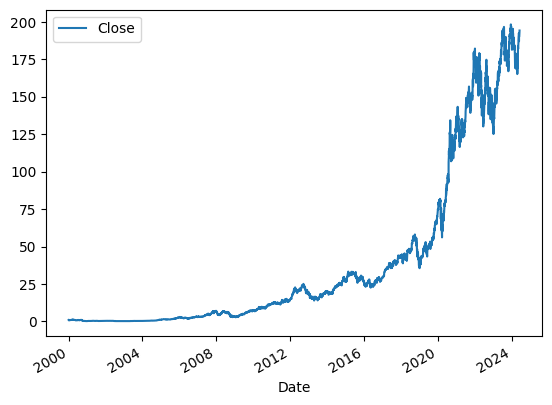

In [3]:
df.plot(y = 'Close')

<Axes: xlabel='Date'>

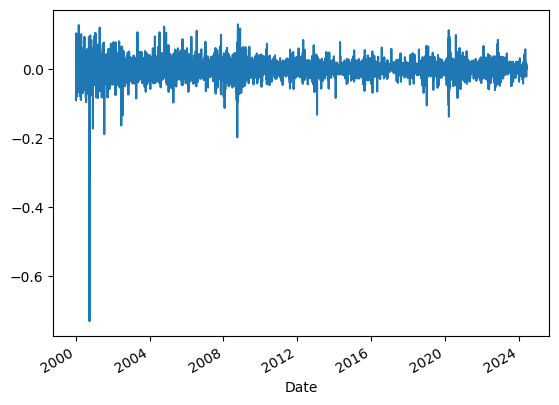

In [4]:
log_returns = np.log(df['Close'] / df['Close'].shift(1)) 
log_returns.plot()

In [5]:

def create_lagged_returns(series: pd.Series, p: int) -> pd.DataFrame:
    """
    Creates a DataFrame with the original series and its p lagged values.

    Args:
        series: The original time series of returns (e.g., log returns).
        p: The number of lags to create.

    Returns:
        A DataFrame with columns y_t, y_t-1, ..., y_t-p
    """

    df = pd.DataFrame(series.copy())           # Start with a copy of the original series
    df.columns = ['y_t']                       # Rename the column for clarity

    for lag in range(1, p + 1):
        lagged_column = f'y_t-{lag}'
        df[lagged_column] = series.shift(lag)  # Create lagged columns
   
    df.dropna(inplace = True)
    
    return df

In [6]:
data = create_lagged_returns(log_returns, p = 10)

data.head()

,y_t,y_t-1,y_t-2,y_t-3,y_t-4,y_t-5,y_t-6,y_t-7,y_t-8,y_t-9,y_t-10
Date,,,,,,,,,,,
2000-01-19,0.024942,0.034254,0.037405,0.104069,-0.061846,-0.052506,-0.017744,0.046281,-0.090514,0.014527,-0.088077
2000-01-20,0.063071,0.024942,0.034254,0.037405,0.104069,-0.061846,-0.052506,-0.017744,0.046281,-0.090514,0.014527
2000-01-21,-0.019461,0.063071,0.024942,0.034254,0.037405,0.104069,-0.061846,-0.052506,-0.017744,0.046281,-0.090514
2000-01-24,-0.046547,-0.019461,0.063071,0.024942,0.034254,0.037405,0.104069,-0.061846,-0.052506,-0.017744,0.046281
2000-01-25,0.054933,-0.046547,-0.019461,0.063071,0.024942,0.034254,0.037405,0.104069,-0.061846,-0.052506,-0.017744


<Axes: >

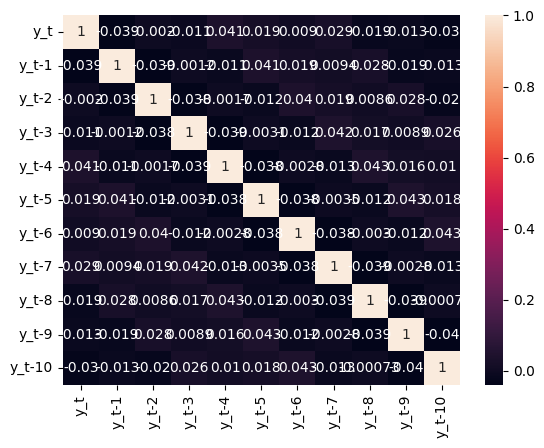

In [7]:
sns.heatmap(data.corr(), annot =  True)

In [8]:
n_cpu                            = multiprocessing.cpu_count()



y, X                             =  data.iloc[:,0], data.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

Fitting of candidate distributions completed: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]        


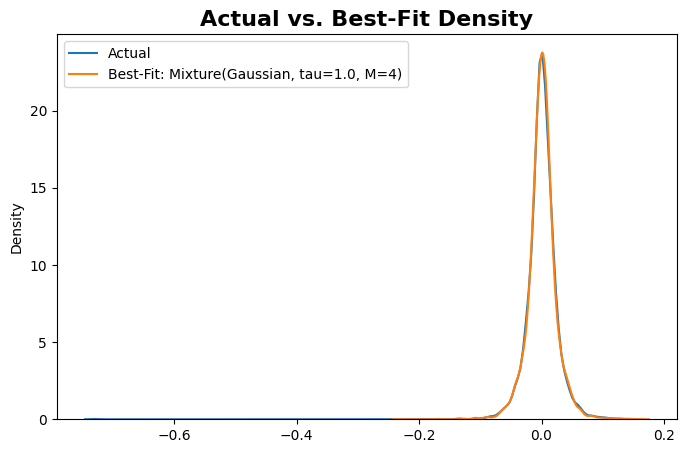

,nll,distribution
rank,,
1,-11863.154297,"Mixture(Gaussian, tau=1.0, M=4)"
2,-11850.399414,"Mixture(Gaussian, tau=1.0, M=3)"
3,-11715.555664,"Mixture(Gaussian, tau=1.0, M=2)"


In [9]:
mix_dist_class = MixtureDistributionClass()

candidate_distributions = [
    Mixture(Gaussian(response_fn="softplus"), M = 2),
    Mixture(Gaussian(response_fn="softplus"), M = 3),
    Mixture(Gaussian(response_fn="softplus"), M = 4),
]

dist_nll = mix_dist_class.dist_select(target=y_train.to_numpy(), candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(8, 5))
dist_nll

In [10]:
# Specifies a mixture of Gaussians. See ?Mixture for an overview.
xgblss = XGBoostLSS(
    Mixture(
        Gaussian(response_fn="softplus"), 
        M = 4,
        tau=1.0,
        hessian_mode="individual",
    )
)

In [11]:
param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=60,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=30,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=True,               # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

Best trial: 11. Best value: -2395.85: 100%|██████████| 30/30 [06:51<00:00, 13.71s/it, 411.18/3600 seconds]


Hyper-Parameter Optimization successfully finished.
  Number of finished trials:  30
  Best trial:
    Value: -2395.8509277999997
    Params: 
    eta: 0.02403176811159078
    max_depth: 1
    gamma: 1.7888219816257436e-05
    subsample: 0.977680074910485
    colsample_bytree: 0.23215141247726845
    min_child_weight: 0.033629979359189745
    booster: gbtree
    opt_rounds: 100


In [12]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds,
             )

[23:50:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
invalid value encountered in divide
invalid value encountered in divide


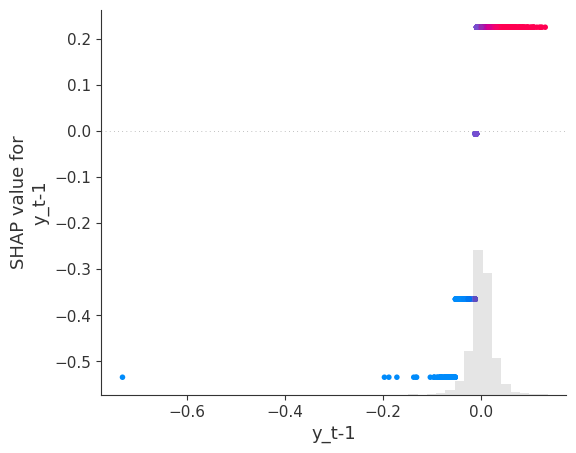

In [13]:
# Partial Dependence Plot
shap_df = pd.DataFrame(X_train, columns= list(X.columns))
xgblss.plot(shap_df,
            parameter="mix_prob_1",
            feature  = list(X.columns)[0],
            plot_type="Partial_Dependence")

[23:50:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
invalid value encountered in divide
invalid value encountered in divide


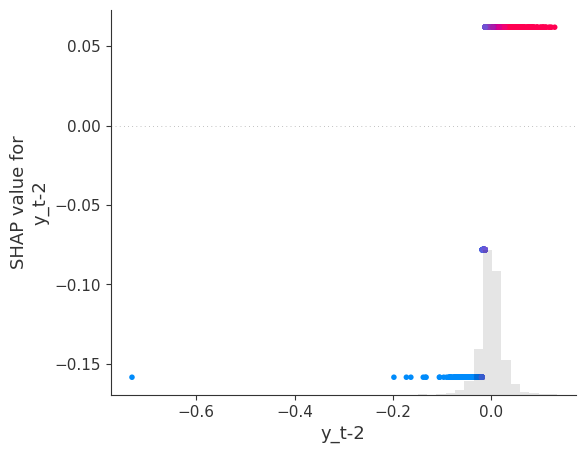

In [14]:
# Partial Dependence Plot
shap_df = pd.DataFrame(X_train, columns= list(X.columns))
xgblss.plot(shap_df,
            parameter="mix_prob_1",
            feature  = list(X.columns)[1],
            plot_type="Partial_Dependence")

[23:50:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
invalid value encountered in divide
invalid value encountered in divide


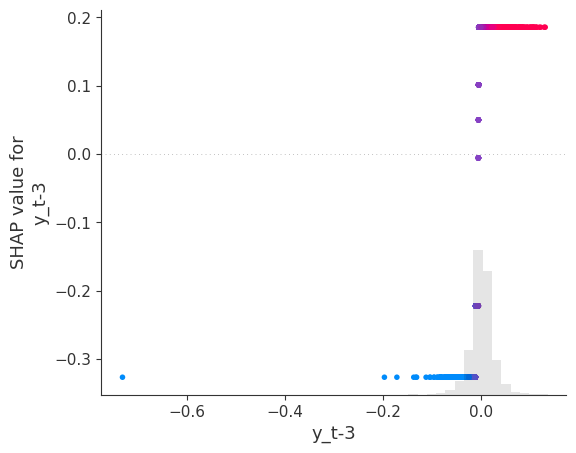

In [15]:
# Partial Dependence Plot
shap_df = pd.DataFrame(X_train, columns= list(X.columns))
xgblss.plot(shap_df,
            parameter="mix_prob_1",
            feature  = list(X.columns)[2],
            plot_type="Partial_Dependence")

In [16]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = y_test.shape[0]
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

C:\Users\vitil\AppData\Local\Temp\ipykernel_22548\2248240304.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
C:\Users\vitil\AppData\Local\Temp\ipykernel_22548\2248240304.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
C:\Users\vitil\AppData\Local\Temp\ipykernel_22548\2248240304.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
C:\Users\vitil\AppData\Local\Temp\ipykernel_22548\2248240304.py:20: FutureWarning: Series.__getitem_

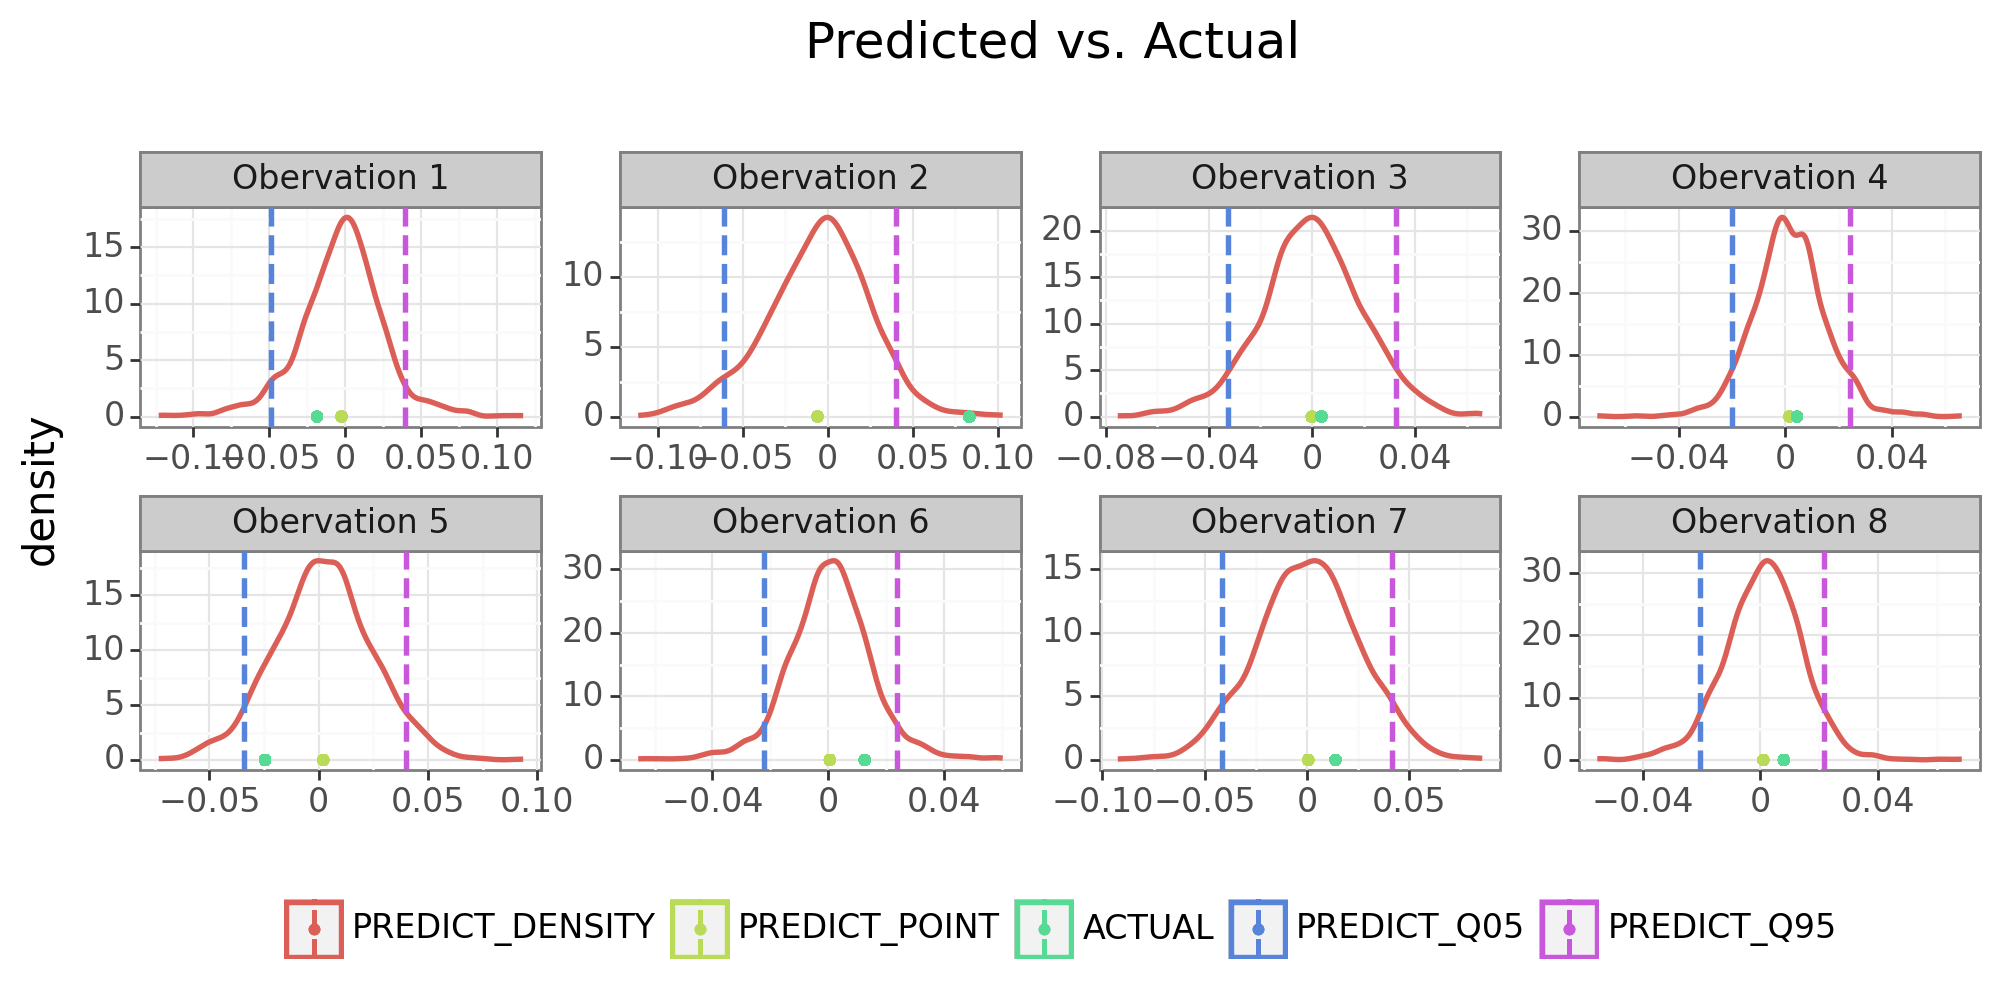

In [17]:
figure_size = (10,5)

import plotnine
from plotnine import *
plotnine.options.figure_size = figure_size


y_pred = []

n_examples = 8
q_sel = [0.05, 0.95]
y_sel=0
samples_arr = pred_samples.values.reshape(-1,n_samples)

for i in range(n_examples):    
    y_samples = pd.DataFrame(samples_arr[i,:].reshape(-1,1), columns=["PREDICT_DENSITY"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENSITY"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENSITY"].quantile(q=q_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENSITY"].quantile(q=q_sel[1])
    y_samples["ACTUAL"] = y_test[i]
    y_samples["obs"]= f"Obervation {i+1}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free",
               ncol=4) + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    theme(plot_title = element_text(hjust = 0.5)) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          legend_title = element_blank()
         )
)

print(plot_pred)